In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.patches as mpatches
import matplotlib.hatch as mhatch
from scipy.stats import t
import math
import numpy as np

## Load Data

Loading data and converting embedding type names to paper-friendly format

In [16]:
embedding_types = {
  'none': 'NONE',
  'onehot':'ONEHOT',
  'uniform75': 'RAND_75',
  'choi300': 'MCEMC_5_300',
  'skipgram75_w5': 'SG_5_75',
  'skipgram75_w10': 'SG_10_75',
  'skipgram150_w5': 'SG_5_150',
  'skipgram150_w10': 'SG_10_150',
  'skipgram300_w5': 'SG_5_300',
  'skipgram300_w10': 'SG_10_300',
  'cbow75_w5': 'CBOW_5_75',
  'cbow75_w10': 'CBOW_10_75',
  'cbow150_w5': 'CBOW_5_150',
  'cbow150_w10': 'CBOW_10_150',
  'cbow300_w5': 'CBOW_5_300',
  'cbow300_w10': 'CBOW_10_300',
}

data = pd.read_csv('../xgboost/test-results.csv')

data['embedding_type'] = data['embedding_type'].map(embedding_types)

## Compute Confidence Intervals

In [17]:
confidence = 0.95
z_val = 1.96

results = []

for (group, df) in data.groupby('embedding_type'):
    m = df['roc_auc'].mean()
    std = df['roc_auc'].std()
    n = len(df)
    if n > 30:
        t_val = z_val
    else:
        t_val = t.ppf((1 + confidence) / 2, n - 1)
    h = (std * t_val) / math.sqrt(n)
    lower_ci, upper_ci = m - h, m + h
    
    results.append([group, m, std, n, t_val, lower_ci, upper_ci])
    
results = pd.DataFrame(results, columns=['embedding_type', 'mean', 'std', 'n', 't-val', 'lower_ci', 'upper_ci'])
results.sort_values(by='mean')

,embedding_type,mean,std,n,t-val,lower_ci,upper_ci
7,NONE,0.837252,0.002185,30,2.04523,0.836436,0.838068
8,ONEHOT,0.843293,0.001095,30,2.04523,0.842884,0.843701
9,RAND_75,0.857412,0.002919,30,2.04523,0.856322,0.858502
0,CBOW_10_150,0.867124,0.002249,30,2.04523,0.866285,0.867964
1,CBOW_10_300,0.867150,0.001950,30,2.04523,0.866421,0.867878
6,MCEMC_5_300,0.867337,0.001526,30,2.04523,0.866767,0.867906
2,CBOW_10_75,0.867996,0.001895,30,2.04523,0.867288,0.868703
3,CBOW_5_150,0.868190,0.002193,30,2.04523,0.867371,0.869009
5,CBOW_5_75,0.868529,0.002469,30,2.04523,0.867607,0.869450
4,CBOW_5_300,0.868560,0.001610,30,2.04523,0.867958,0.869161


## Box Plot Results

In [18]:
order = results.sort_values(by='mean')['embedding_type'].values

colors = sns.color_palette('Accent')

def get_color(embedding_type):
  if embedding_type == 'NONE':
    return 'lightgray'
  if embedding_type == 'ONEHOT':
    return colors[1]
  if 'RAND' in embedding_type:
    return colors[2]
  if 'MCEMC' in embedding_type:
    return 'salmon'
  if 'SG' in embedding_type:
    return colors[4]
  if 'CBOW' in embedding_type:
    return colors[0]
  
def get_pattern(idx):
  if idx == 0:
    return ''
  if idx == 1:
    return '/'
  if idx == 2:
    return '\\'
  if idx in [3, 4, 6, 7, 8, 9]:
    return '///'
  if idx == 5:
    return '.'
  return 'x'
  
#   if 'RAND' in embedding_type:
#     return 'o'
#   if 'MCEMC' in embedding_type:
#     return '*'
#   if 'SG' in embedding_type:
#     return '///'
#   if 'CBOW' in embedding_type:
#     return 'x'
  
palette = { x: get_color(x) for x in embedding_types.values() }

legend_elements = [
  mpatches.Patch(color='lightgray', label='NONE',),
  mpatches.Patch(color=colors[1], label='ONEHOT', hatch='/'),
  mpatches.Patch(color=colors[2], label='RAND', hatch='\\'),
  mpatches.Patch(color='salmon', label='MCEMC', hatch='o'),
  mpatches.Patch(color=colors[4], label='SG', hatch='x'),
  mpatches.Patch(color=colors[0], label='CBOW', hatch='///'),
]

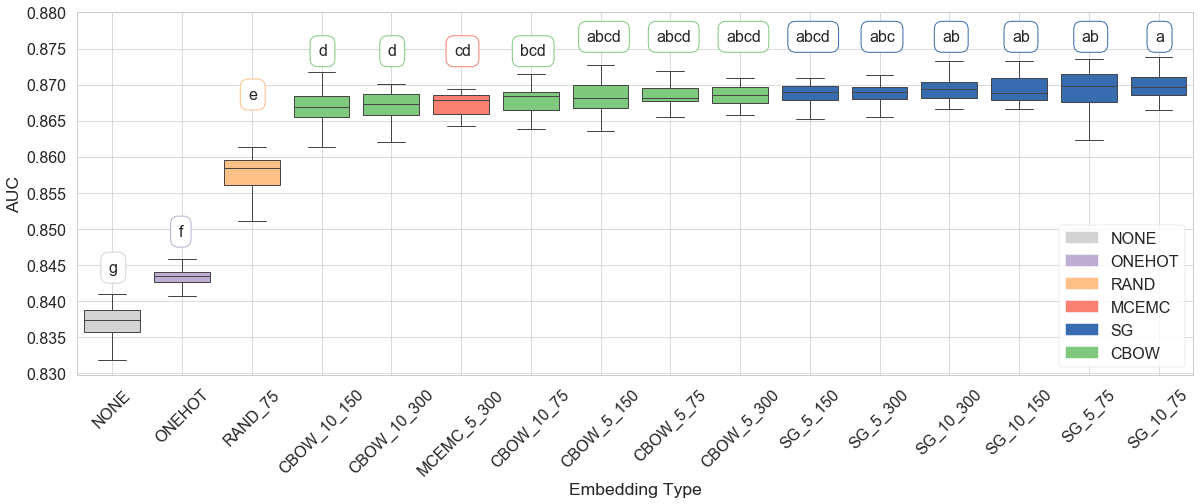

In [19]:
figure(num=None, figsize=(20, 8), facecolor='w', edgecolor='k')

plt.style.use(['ggplot', 'seaborn-whitegrid', 'seaborn-poster'])

chart = sns.boxplot(data=data, x='embedding_type', y='roc_auc', 
                    saturation=1, order=order, palette=palette,
                    showfliers=False, width=0.8, linewidth=1)

chart.set_xticklabels(labels=order, rotation=45);
plt.xlabel('Embedding Type');
plt.ylabel('AUC');
plt.yticks(np.arange(0.83, 0.88, 0.005));
# plt.title('AUC Results and HSD Groups by Embedding Type');
plt.legend(handles=legend_elements, loc='lower right', frameon=True);
plt.grid(linestyle='-', linewidth=0.7);

# add hatches to boxplots
# for idx, patch in enumerate(chart.artists):
#     patch.set_hatch(get_pattern(idx))
    
# Add labels to the plot
text_style = dict(size=16)
box_lw = 1

chart.text(0-0.05, 0.844, "g", bbox=dict(boxstyle='round,pad=0.5', fc="white", ec=get_color('NONE'), lw=1), **text_style)
chart.text(1-0.05, 0.849, "f", bbox=dict(boxstyle='round,pad=0.5', fc="white", ec=get_color('ONEHOT'), lw=box_lw), **text_style)
chart.text(2-0.05, 0.868, "e", bbox=dict(boxstyle='round,pad=0.5', fc="white", ec=get_color('RAND'), lw=box_lw), **text_style)
chart.text(3-0.05, 0.874, "d", bbox=dict(boxstyle='round,pad=0.5', fc="white", ec=get_color('CBOW'), lw=box_lw), **text_style)
chart.text(4-0.05, 0.874, "d", bbox=dict(boxstyle='round,pad=0.5', fc="white", ec=get_color('CBOW'), lw=box_lw), **text_style)
chart.text(5-0.1, 0.874, "cd", bbox=dict(boxstyle='round,pad=0.5', fc="white", ec=get_color('MCEMC'), lw=box_lw), **text_style)
chart.text(6-0.15, 0.874, "bcd", bbox=dict(boxstyle='round,pad=0.5', fc="white", ec=get_color('CBOW'), lw=box_lw), **text_style)
chart.text(7-0.2, 0.876, "abcd", bbox=dict(boxstyle='round,pad=0.5', fc="white", ec=get_color('CBOW'), lw=box_lw), **text_style)
chart.text(8-0.2, 0.876, "abcd", bbox=dict(boxstyle='round,pad=0.5', fc="white", ec=get_color('CBOW'), lw=box_lw), **text_style)
chart.text(9-0.2, 0.876, "abcd", bbox=dict(boxstyle='round,pad=0.5', fc="white", ec=get_color('CBOW'), lw=box_lw), **text_style)
chart.text(10-0.2, 0.876, "abcd", bbox=dict(boxstyle='round,pad=0.5', fc="white", ec=get_color('SG'), lw=box_lw), **text_style)
chart.text(11-0.15, 0.876, "abc", bbox=dict(boxstyle='round,pad=0.5', fc="white", ec=get_color('SG'), lw=box_lw), **text_style)
chart.text(12-0.1, 0.876, "ab", bbox=dict(boxstyle='round,pad=0.5', fc="white", ec=get_color('SG'), lw=box_lw), **text_style)
chart.text(13-0.1, 0.876, "ab", bbox=dict(boxstyle='round,pad=0.5', fc="white", ec=get_color('SG'), lw=box_lw), **text_style)
chart.text(14-0.1, 0.876, "ab", bbox=dict(boxstyle='round,pad=0.5', fc="white", ec=get_color('SG'), lw=box_lw), **text_style)
chart.text(15-0.05, 0.876, "a", bbox=dict(boxstyle='round,pad=0.5', fc="white", ec=get_color('SG'), lw=box_lw), **text_style)

plt.gcf().subplots_adjust(bottom=0.25)

plt.savefig('auc-results.jpg')